In [175]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt 

In [176]:
NUM_OF_AGENTS = 1000

# PLACES
PARK = 0
HOME = 1
GROCERY = 2
QC = 3 # Quarantine center
VC = 4 # Vaccination center 

# There needs to be a place, vaccination center, where agents can get vaccinated
# Vaccination center can only vaccinate 10 agents each day
VC_LIMIT = 10 

# INFECTION STATES *** Revised infection states
NOT_INFECTED = 0
INFECTED_A = 1 #Asymptomatic
INFECTED_S_MILD = 2 # Symptomatic Mild
INFECTED_S_CRITICAL = 3 # Symptomatic INFECTED_S_CRITICAL
RECOVERED = 4 # Recovered
DECEASED = 5 # Deceased 

# Capacity of quarantine center
QC_LIMIT = 100 # Capacity of quarantine center

# DiseaseStateTransitionProbabilities
ALPHA_V = 0.5 # vaccinated
ALPHA_NV = 1 # not vaccinated
BETA_NH = 1 # not staying at home
BETA_H = 2 # staying at home

PROB_notinf_to_infa = 0.8
PROB_infa_to_infm = 0.36
PROB_infm_to_infc = 0.01
PROB_infa_to_rec = 0.2
PROB_infm_to_rec = 0.1
PROB_infc_to_rec = 0.05
PROB_infc_to_dec = 0.2

In [177]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class HumanAgent(Agent):

    def __init__(self, unique_id, model):

        super().__init__(unique_id, model)

        self.homeId = unique_id//4 
        self.health = NOT_INFECTED # Initialized as not infected
        self.vaccinated = 0 # Initialized as not vaccincated
        self.wearMask = 0 # Initialized as not wearing mask
        self.alpha = ALPHA_NV # Alpha when not vaccinated
        self.beta = BETA_NH # Beta when not at home
        self.compliance_attitude = 1 #Default as fully compliant; set actual value when initializing the agents
        self.payoff_history = {}

    def step(self):
        self.updateHealth()
        self.move()

    # Function for mobility pattern modeling
    
    def move(self):

        x, y = self.pos
        newX = x
        newY = y
        
        if x==QC:
            return
        
        if self.model.quarantine and self.model.QC_Occupancy < QC_LIMIT and self.health == INFECTED_S_CRITICAL:
            self.model.grid.move_agent(self, (QC,0))
            self.model.QC_Occupancy += 1
            return
        
        if self.model.quarantine and self.model.QC_Occupancy < QC_LIMIT and self.health == INFECTED_S_MILD and self.random.uniform(0, 1) <= 0.20:
            self.model.grid.move_agent(self, (QC,0))
            self.model.QC_Occupancy += 1
            return
        
        if x == HOME:

            p = self.random.uniform(0, 1)
            
            # Visit park with 10% probability
            if p <= 0.1:
                newX = PARK
                newY = self.random.choice((0,1)) # Visit one of the two parks
              # Visit grocery store with 20% probability
            elif p <= 0.3:
                newX = GROCERY
                newY = self.random.choice((0,1,2,3,4)) # Visit one of the five grocery stores
            # Visit VC with 10% probability
            elif p <= 0.4 and self.model.VC_Occupancy < VC_LIMIT and self.vaccinated == 0:
            # FOR INCLUDING COMPLIANCE ATTITUDE COMMENT THE PREVIOUS LINE AND UNCOMMENT THE NEXT LINE
            # elif p <= 0.3 + 0.1*self.compliance_attitude and self.model.VC_Occupancy < VC_LIMIT and self.vaccinated == 0:
                newX = VC
                newY = 0
                self.model.VC_Occupancy += 1
                self.vaccinated = 1
                self.alpha = ALPHA_V
            else:
                newX = x
                newY = y

        # VC to be added here
        if x == GROCERY or x == PARK or x == VC: # If grocery, park, or vaccine center, return home
            newX = HOME
            newY = self.homeId
            if x == VC:
                self.model.VC_Occupancy -= 1
        
        if newX == HOME: 
            self.beta = BETA_H
        else:
            self.beta = BETA_NH

        # Decision to wear mask everyday based on compliance attitude 
        p = self.random.uniform(0, 1)

        if p < self.compliance_attitude:
            self.wearMask = 1
            
        self.model.grid.move_agent(self, (newX,newY))

    # Function for modeling the spread of the virus
    # Social distancing or mask wearing currently has no affect; updateHealth should be revised

    def updateHealth(self):

        p = self.random.uniform(0, 1)
        
        if self.health == INFECTED_A and p < (self.model.p_infa_to_infm * self.alpha):
            self.health = INFECTED_S_MILD
        elif self.health == INFECTED_A and p > 1 - (self.model.p_infa_to_rec * self.beta):
            self.health = NOT_INFECTED
        elif self.health == INFECTED_S_MILD and p < (self.model.p_infm_to_infc * self.alpha):
            self.health = INFECTED_S_CRITICAL
        elif self.health == INFECTED_A and p > 1 - (self.model.p_infm_to_rec * self.beta):
            self.health = NOT_INFECTED
            x,y = self.pos
            if x == QC:
                self.model.QC_Occupancy -= 1                
        elif self.health == INFECTED_S_CRITICAL and p < (self.model.p_infc_to_dec * self.alpha):
            self.health = DECEASED
            self.model.deceasedCount += 1
            x,y = self.pos
            if x == QC:
                self.model.QC_Occupancy -= 1
            if x == VC:
                self.model.VC_Occupancy -= 1
        elif self.health == INFECTED_S_CRITICAL and p > 1 - (self.model.p_infm_to_rec * self.beta):
            self.health = NOT_INFECTED
            x,y = self.pos
            if x == QC:
                self.model.QC_Occupancy -= 1  
                
        return
    
    def infect(self):
        p = self.random.uniform(0, 1)
        if self.health == NOT_INFECTED and p < (self.model.p_notinf_to_infa*self.alpha):
                self.health += INFECTED_A

def compute_infected(model):
    infectedAgents = [agent for agent in model.schedule.agents if agent.health in (INFECTED_A, INFECTED_S_MILD, INFECTED_S_CRITICAL) ]
    return len(infectedAgents)

class CovidModel(Model):

    """A model with some number of agents."""
    def __init__(self, N, startingState, complianceList, quarantine = False, socialDistancing = False):

        self.num_agents = N
        # self.random.seed(42)
        self.QC_Occupancy = 0
        self.VC_Occupancy = 0 #Variable for VC_Occupancy
        self.deceasedCount = 0
        self.quarantine = quarantine
        # self.grid = MultiGrid(5 if quarantine else 4, 250, False) 
        self.grid = MultiGrid(5, 250, False) # Grid for five places (Home, Park, Grocery, QC, and VC)
        self.schedule = RandomActivation(self)
        self.running = True
        self.p_notinf_to_infa = PROB_notinf_to_infa
        self.p_infa_to_infm = PROB_infa_to_infm
        self.p_infm_to_infc = PROB_infm_to_infc
        self.p_infa_to_rec = PROB_infa_to_rec
        self.p_infm_to_rec = PROB_infm_to_rec
        self.p_infc_to_rec = PROB_infc_to_rec
        self.p_infc_to_dec = PROB_infc_to_dec
        
        # Create agents
        for i in range(self.num_agents):

            a = HumanAgent(i, self)
            a.compliance_attitude = complianceList[i] # Compliance value is set here
            
            self.schedule.add(a)
            self.grid.place_agent(a, (HOME, a.homeId))
        
        for a in self.random.sample(self.schedule.agents,int(startingState*N)):
            a.health = INFECTED_A
        # Data collector helps to collect data at agent level and model level
        # https://buildmedia.readthedocs.org/media/pdf/mesa/master/mesa.pdf (See Section 4.6.3, pg 42)
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_infected,
                             "QC_Occupancy": "QC_Occupancy"}
            )
        
    def step(self):

        self.datacollector.collect(self)
        '''Advance the model by one step.'''
        self.schedule.step()
        self.identifyAgentsAndUpdateSpread()

    def identifyAgentsAndUpdateSpread(self):

        # Park
        for y in range(2):
            agents = self.grid.get_cell_list_contents([(PARK,y)])
            self.updateSpread(agents)
        
        # Grocery
        for y in range(5):
            agents = self.grid.get_cell_list_contents([(GROCERY,y)])
            self.updateSpread(agents)
        
        # Home
        for y in range(250):
            agents = self.grid.get_cell_list_contents([(HOME,y)])
            self.updateSpread(agents)
    
    def updateSpread(self, agents):
        if any(a.health in (INFECTED_A, INFECTED_S_MILD, INFECTED_S_CRITICAL) for a in agents):
            [a.infect() for a in agents]

In [178]:

def runSimulation(startingState, complianceList, quarantine=False,socialDistancing=False):
    
    modelInst = CovidModel(NUM_OF_AGENTS, startingState, complianceList, quarantine, socialDistancing,)
    i=0
    
    while any(a.health in (INFECTED_A, INFECTED_S_MILD, INFECTED_S_CRITICAL) and i<=500 for a in modelInst.schedule.agents):
        i += 1
#         if i%100 == 0:
#             print(i)
        modelInst.step()
    
    modelDF = modelInst.datacollector.get_model_vars_dataframe()
    
    return i, modelInst.deceasedCount, modelDF.QC_Occupancy, modelDF.Infected

# Scenario 1a. No Quarantine Centers and No Social Distancing; 10% Infection at Start
StartingState = 10%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 150.3
Average of the Day with peak Infection (290.2): 3.6
Average Number of Casualties: 189.7


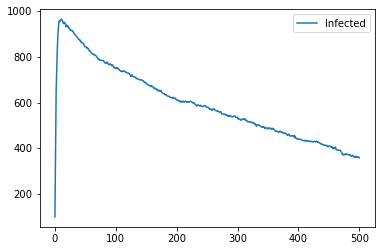

In [179]:
StartingState = 0.1
quarantine=False
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

# Array to set agents with compliance as 1
# complianceList = np.full(NUM_OF_AGENTS, fill_value=1, dtype=int)

# Array to set agents with compliance with uniform distribution from 0 to 1
complianceList = np.arange(0, 1, 1/NUM_OF_AGENTS)

for i in range(3):
    
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,complianceList,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties
    
    if i == 2:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))


<AxesSubplot:>

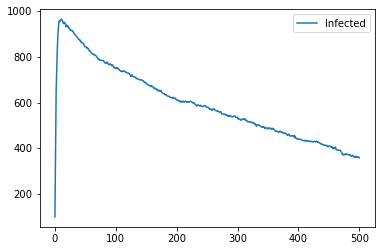

In [180]:
Infected.plot(legend=True)

# Scenario 1b. No Quarantine Centers and No Social Distancing; 25% Infection at Start
StartingState = 25%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 150.3
Average of the Day with peak Infection (289.5): 2.7
Average Number of Casualties: 192.6


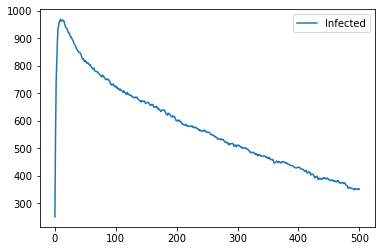

In [181]:
StartingState = 0.25
quarantine=False
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

# Array to set agents with compliance as 1
complianceList = np.full(NUM_OF_AGENTS, fill_value=1, dtype=int)

# Array to set agents with compliance with uniform distribution from 0 to 1
# compliance = np.arange(0, 1, 1/NUM_OF_AGENTS)

for i in range(3):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,complianceList,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties
    
    if i == 2:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

<AxesSubplot:>

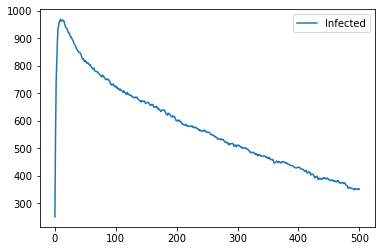

In [182]:
Infected.plot(legend=True)

# Scenario 1c. No Quarantine Centers and No Social Distancing; 50% Infection at Start
StartingState = 50%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 150.3
Average of the Day with peak Infection (291.4): 2.3
Average Number of Casualties: 188.4


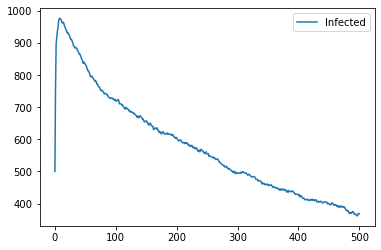

In [183]:
StartingState = 0.5
quarantine=False
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

# Array to set agents with compliance as 1
complianceList = np.full(NUM_OF_AGENTS, fill_value=1, dtype=int)

# Array to set agents with compliance with uniform distribution from 0 to 1
# compliance = np.arange(0, 1, 1/NUM_OF_AGENTS)

for i in range(3):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,complianceList,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties
    
    if i == 2:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

<AxesSubplot:>

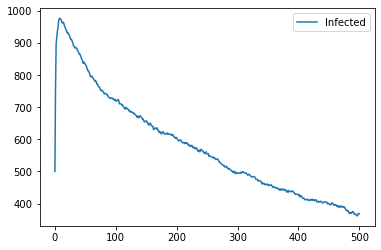

In [184]:
Infected.plot(legend=True)

# Adding Quarantine Centers
Enable quarantine centers for each baseline and see how the plots change
In the line plot, include a plot for capacity of qurantine center too

In [185]:
# Add code to generate plots with quarantine centers here

# Scenario 2a. Quarantine Centers; 10% Infection at start)
StartingState = 10%

Quarantine=True

Social Distancing=False

Average number of days before stabilization: 150.3
Average of the Day with peak Infection (288.9): 3.1
Average Number of Casualties: 174.0
Average of Max Quarantine centre capacity utilized: 30.0
Average of Max Quarantine centre capacity utilized at: 1.0


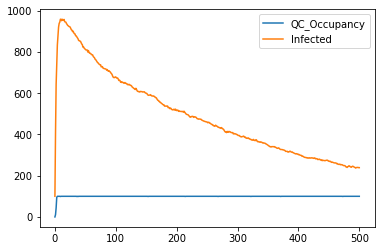

In [186]:
StartingState = 0.1
quarantine=True
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0

# Array to set agents with compliance as 1
complianceList = np.full(NUM_OF_AGENTS, fill_value=1, dtype=int)

# Array to set agents with compliance with uniform distribution from 0 to 1
# compliance = np.arange(0, 1, 1/NUM_OF_AGENTS)

for i in range(3):
    
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,complianceList,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    
    if i == 2:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Scenario 2b. Quarantine Centers; 25% Infection at Start
StartingState = 25%

Quarantine=True

Social Distancing=False

Average number of days before stabilization: 150.3
Average of the Day with peak Infection (288.5): 3.4
Average Number of Casualties: 176.0
Average of Max Quarantine centre capacity utilized: 30.0
Average of Max Quarantine centre capacity utilized at: 0.9


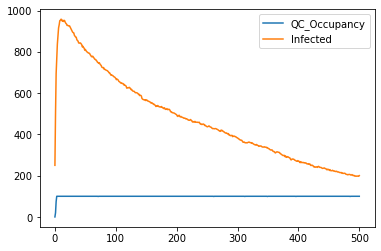

In [187]:
StartingState = 0.25
quarantine=True
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0

# Array to set agents with compliance as 1
complianceList = np.full(NUM_OF_AGENTS, fill_value=1, dtype=int)

# Array to set agents with compliance with uniform distribution from 0 to 1
# compliance = np.arange(0, 1, 1/NUM_OF_AGENTS)

for i in range(3):
    
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,complianceList,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    
    if i == 2:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Scenario 2c. Quarantine Centers; 50% Infection at Start
StartingState = 50%

Quarantine=True

Social Distancing=False

Average number of days before stabilization: 150.3
Average of the Day with peak Infection (290.7): 2.5
Average Number of Casualties: 177.2
Average of Max Quarantine centre capacity utilized: 30.0
Average of Max Quarantine centre capacity utilized at: 0.7


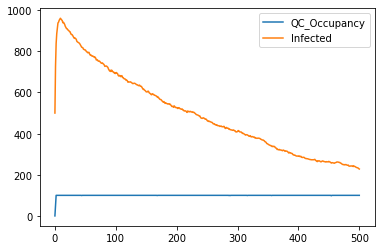

In [188]:
StartingState = 0.50
quarantine=True
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0

# Array to set agents with compliance as 1
complianceList = np.full(NUM_OF_AGENTS, fill_value=1, dtype=int)

# Array to set agents with compliance with uniform distribution from 0 to 1
# compliance = np.arange(0, 1, 1/NUM_OF_AGENTS)

for i in range(3):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,complianceList,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    
    if i == 2:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))